In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid 
import warnings
import time
warnings.filterwarnings("ignore")

# Function to load MVTec images from a specific folder structure
def load_mvtec_images(path, size=(128, 128), color=True):
    images = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    if color:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, size)
                    images.append(img)
    return np.array(images)

# Load data for a given category in an unsupervised manner
def load_data(category, dataset_root='dataset/MVTec'):
    category_path = os.path.join(dataset_root, category)
    train_good_path = os.path.join(category_path, 'train', 'good')
    test_path = os.path.join(category_path, 'test')
    # Load normal images from train/good
    print(f"Loading normal images from {train_good_path}...")
    train_normal_images = load_mvtec_images(train_good_path)
    print(f"Loaded {len(train_normal_images)} normal images from {train_good_path}")
    # Load all images from test folder
    test_images = []
    test_labels = []
    for subfolder in os.listdir(test_path):
        subfolder_path = os.path.join(test_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = 0 if subfolder == 'good' else 1
            print(f"Loading images from {subfolder_path}...")
            images = load_mvtec_images(subfolder_path)
            test_images.append(images)
            test_labels.append(np.full(images.shape[0], label))
            print(f"Loaded {images.shape[0]} images from {subfolder_path}")
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels).reshape(-1, 1)
    print(f"Total normal images loaded for training: {len(train_normal_images)}")
    print(f"Total images loaded for testing: {len(test_images)}")
    return train_normal_images, test_images, test_labels

category = 'pill'
train_images, test_images, test_labels = load_data(category)

Loading normal images from dataset/MVTec\pill\train\good...
Loaded 267 normal images from dataset/MVTec\pill\train\good
Loading images from dataset/MVTec\pill\test\color...
Loaded 25 images from dataset/MVTec\pill\test\color
Loading images from dataset/MVTec\pill\test\combined...
Loaded 17 images from dataset/MVTec\pill\test\combined
Loading images from dataset/MVTec\pill\test\contamination...
Loaded 21 images from dataset/MVTec\pill\test\contamination
Loading images from dataset/MVTec\pill\test\crack...
Loaded 26 images from dataset/MVTec\pill\test\crack
Loading images from dataset/MVTec\pill\test\faulty_imprint...
Loaded 19 images from dataset/MVTec\pill\test\faulty_imprint
Loading images from dataset/MVTec\pill\test\good...
Loaded 26 images from dataset/MVTec\pill\test\good
Loading images from dataset/MVTec\pill\test\pill_type...
Loaded 9 images from dataset/MVTec\pill\test\pill_type
Loading images from dataset/MVTec\pill\test\scratch...
Loaded 24 images from dataset/MVTec\pill\test

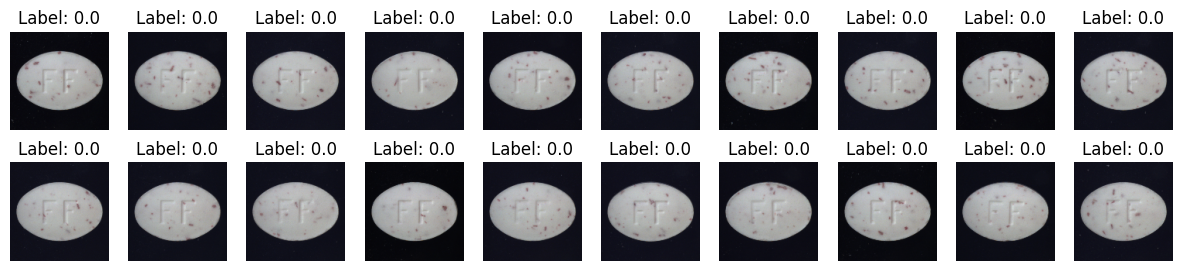

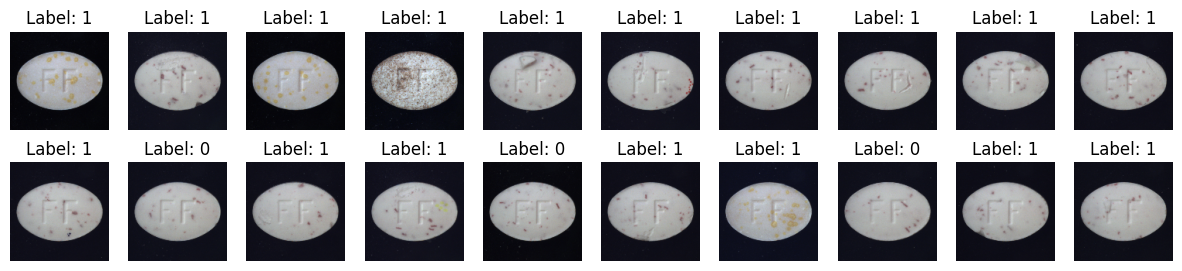

In [2]:
def plot_data(images, labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select indices
    for i, idx in enumerate(indices):
        axs[i].imshow(images[idx])
        axs[i].set_title(f"Label: {labels[idx]}")
        axs[i].axis("off")
    plt.show()

# Plot random sample images from the training set
plot_data(train_images, np.zeros(len(train_images)), n=20)

# Plot random sample images from the test set
plot_data(test_images, test_labels.flatten(), n=20)


In [3]:
# Shuffle training data
def shuffle_data(data):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx]

train_images = shuffle_data(train_images)
test_images = shuffle_data(test_images)
test_labels = shuffle_data(test_labels)



In [4]:
# HOG Feature Extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Resize image to 128x128
        resized_image = cv2.resize(gray_image, (128, 128))
        
        # Extract HOG features
        fd, _ = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Extract HOG features for training and testing images
train_images_hog = extract_hog_features(train_images)
test_images_hog = extract_hog_features(test_images)


print("\nExtracted features data shapes:")
print("Train images HOG:", train_images_hog.shape)
print("Test images HOG:", test_images_hog.shape)




Extracted features data shapes:
Train images HOG: (267, 512)
Test images HOG: (167, 512)


In [5]:
# Normalize data
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

normalized_train_images = min_max_scaling(train_images_hog)
normalized_test_images = min_max_scaling(test_images_hog)

print("\nNormalized features of hog data shapes:")
print("Normalized train images of HOG:", normalized_train_images.shape)
print("Normalized test images of HOG:", normalized_test_images.shape)




Normalized features of hog data shapes:
Normalized train images of HOG: (267, 512)
Normalized test images of HOG: (167, 512)


In [6]:
# Dimensionality reduction using PCA
def PCA(train_data, alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    cov_matrix = np.dot(centered_data.T, centered_data)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    total = np.sum(eig_values)
    k = 0
    var = 0
    while var / total < alpha:
        var += eig_values[k]
        k += 1
    eig_vectors = eig_vectors[:, :k]
    return eig_vectors, mean

# Apply PCA on normalized training data
pca_components, mean = PCA(normalized_train_images)

# Project the normalized training and testing data onto the PCA components
train_projected_pca = np.dot(normalized_train_images - mean, pca_components)
test_projected_pca = np.dot(normalized_test_images - mean, pca_components)
print(f"\nPCA - Number of components retained: {pca_components.shape[1]}")

print("\nProjected data shapes after PCA:")
print("Projected train images:", train_projected_pca.shape)
print("Projected test images:", test_projected_pca.shape)




PCA - Number of components retained: 146

Projected data shapes after PCA:
Projected train images: (267, 146)
Projected test images: (167, 146)


In [7]:
# Custom implementation of K-Means with convergence iteration tracking
def k_means(X, n_clusters, max_iters=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, n_clusters, replace=False)]
    centroid_history = [centroids.copy()]  # Track centroid history
    for iter_ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        centroid_history.append(new_centroids.copy())  # Track new centroids
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels, centroids, iter_ + 1, centroid_history


With Out PCA (HOG) - DBSCAN
Testing Accuracy: 84.4311
F1 Score: 0.4578
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


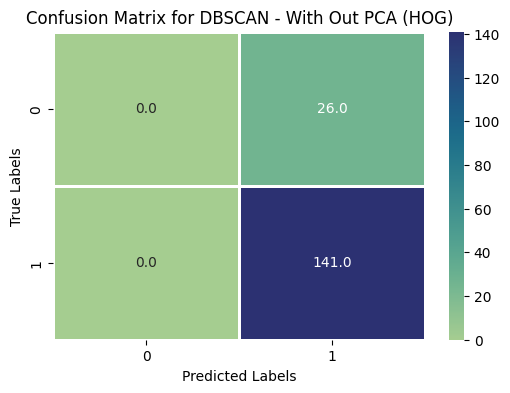

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.84      1.00      0.92       141

    accuracy                           0.84       167
   macro avg       0.42      0.50      0.46       167
weighted avg       0.71      0.84      0.77       167

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - DBSCAN
Testing Accuracy: 84.4311
F1 Score: 0.4578
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


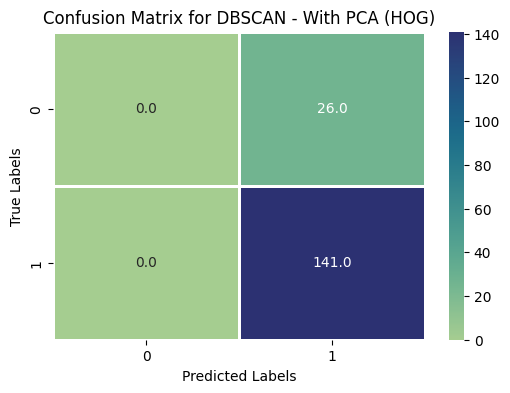

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.84      1.00      0.92       141

    accuracy                           0.84       167
   macro avg       0.42      0.50      0.46       167
weighted avg       0.71      0.84      0.77       167

------------------------------------------------------------------------------------------------------------------------
With Out PCA (HOG) - Gaussian Mixture Model
Testing Accuracy: 15.5689
F1 Score: 0.1347
Best Hyperparameters: {}


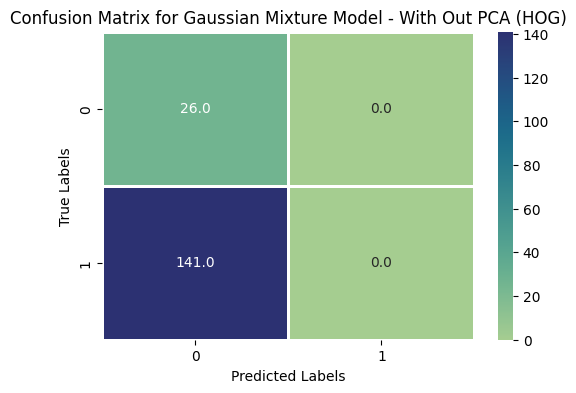

Classification Report:
              precision    recall  f1-score   support

           0       0.16      1.00      0.27        26
           1       0.00      0.00      0.00       141

    accuracy                           0.16       167
   macro avg       0.08      0.50      0.13       167
weighted avg       0.02      0.16      0.04       167

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - Gaussian Mixture Model
Testing Accuracy: 15.5689
F1 Score: 0.1347
Best Hyperparameters: {}


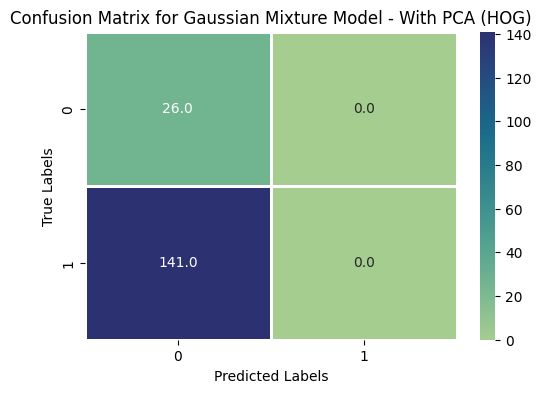

Classification Report:
              precision    recall  f1-score   support

           0       0.16      1.00      0.27        26
           1       0.00      0.00      0.00       141

    accuracy                           0.16       167
   macro avg       0.08      0.50      0.13       167
weighted avg       0.02      0.16      0.04       167

------------------------------------------------------------------------------------------------------------------------
With Out PCA (HOG) - K-Means
Testing Accuracy: 71.2575
F1 Score: 0.5124
Best Hyperparameters: {}


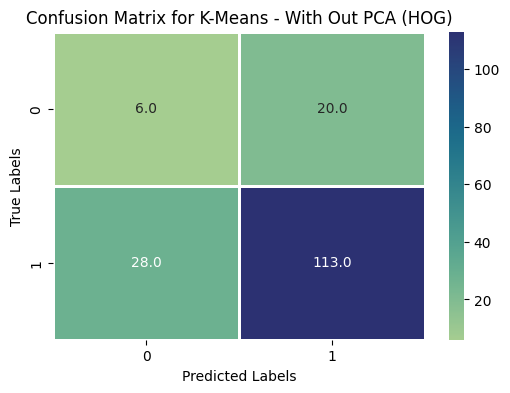

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.23      0.20        26
           1       0.85      0.80      0.82       141

    accuracy                           0.71       167
   macro avg       0.51      0.52      0.51       167
weighted avg       0.74      0.71      0.73       167

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - K-Means
Testing Accuracy: 28.1437
F1 Score: 0.2802
Best Hyperparameters: {}


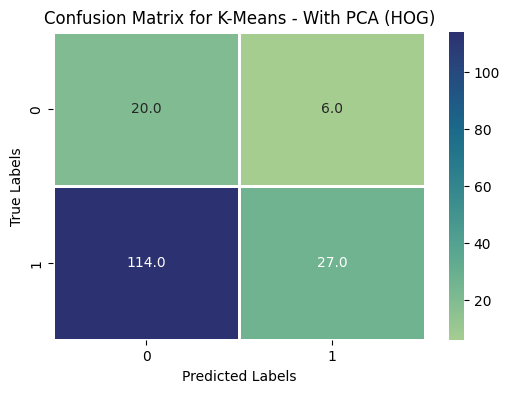

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.77      0.25        26
           1       0.82      0.19      0.31       141

    accuracy                           0.28       167
   macro avg       0.48      0.48      0.28       167
weighted avg       0.71      0.28      0.30       167

------------------------------------------------------------------------------------------------------------------------

The Best model is: K-Means with With Out PCA method, having an F1 score of 0.5124
Hyperparameters: {}




In [10]:

classifiers = [
    ("DBSCAN", DBSCAN(), {'eps': [0.1, 0.5, 1], 'min_samples': [5, 10, 20]}),
    ("Gaussian Mixture Model", GaussianMixture(n_components=2), {}),  
    ("K-Means", KMeans(n_clusters=2), {})  
    
]

# Initialize lists to store classifier names, training accuracies, test accuracies, and F1-scores
classifier_names = []
test_accuracies = []
f1_scores = []
hyperparameters = []

X_for_training = [normalized_train_images, train_projected_pca]
X_for_test = [normalized_test_images, test_projected_pca]

text = ['With Out PCA', 'With PCA']

# Function to perform hyperparameter tuning and evaluation
def evaluate_classifier(name, classifier, param_grid, X_train, X_test, y_test, feature_text):
    # Hyperparameter tuning
    best_params = None
    best_score = -1
    for params in ParameterGrid(param_grid):
        classifier.set_params(**params)
        if isinstance(classifier, GaussianMixture):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        elif isinstance(classifier, KMeans):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        elif isinstance(classifier, DBSCAN):
            classifier.fit(X_train)
            predictions = classifier.fit_predict(X_train)
            predictions = np.where(predictions == -1, 1, 0)  # Treat -1 as anomaly (1) and other labels as normal (0)
        elif isinstance(classifier, MeanShift):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        else:
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
        score = f1_score(np.ones_like(predictions), predictions, average='macro')
        if score > best_score:
            best_params = params
            best_score = score
    classifier.set_params(**best_params)
    
    # Evaluate on test data
    if isinstance(classifier, GaussianMixture):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    elif isinstance(classifier, KMeans):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    elif isinstance(classifier, DBSCAN):
        predictions = classifier.fit_predict(X_test)
        predictions = np.where(predictions == -1, 1, 0)  # Treat -1 as anomaly (1) and other labels as normal (0)
    elif isinstance(classifier, MeanShift):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    else:
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 1, 0, 1)  # Treat 1 as normal (0) and -1 as anomaly (1)
    
    test_score = accuracy_score(y_test, predictions)
    current_f1_score = f1_score(y_test, predictions, average='macro')
    
    # Print the results
    print(f"{feature_text} - {name}")
    print(f"Testing Accuracy: {test_score * 100:.4f}")
    print(f"F1 Score: {current_f1_score:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    
    # Plot the confusion matrix
    conmat = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conmat, annot=True, fmt=".1f", linewidth=1, cmap="crest")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {name} - {feature_text}")
    plt.show()
    
    # Print the classification report
    class_report = classification_report(y_test, predictions)
    print("Classification Report:")
    print(class_report)
    print("-" * 120)
    
    # Append results to lists
    classifier_names.append(name)
    test_accuracies.append(test_score)
    f1_scores.append(current_f1_score)
    hyperparameters.append(str(best_params))

# Evaluate classifiers
for name, classifier, param_grid in classifiers:
    for i in range(len(text)):
        evaluate_classifier(name, classifier, param_grid, X_for_training[i], X_for_test[i], test_labels, f"{text[i]} (HOG)")

# Print the best model information
best_model_info = {'name': None, 'feature_extraction': None, 'f1_score': 0, 'hyperparameters': None}
for name, feature_extraction, f1, params in zip(classifier_names, [text[i % len(text)] for i in range(len(classifier_names))], f1_scores, hyperparameters):
    if f1 > best_model_info['f1_score']:
        best_model_info['name'] = name
        best_model_info['feature_extraction'] = feature_extraction
        best_model_info['f1_score'] = f1
        best_model_info['hyperparameters'] = params
print(f"\nThe Best model is: {best_model_info['name']} with {best_model_info['feature_extraction']} method, having an F1 score of {best_model_info['f1_score']:.4f}")
print(f"Hyperparameters: {best_model_info['hyperparameters']}\n\n")

In [9]:
from sklearn.model_selection import ParameterGrid 
